In [73]:
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
np.random.seed = 42
def tokenize(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return list(words)
text = ""
with open(r"train.txt", 'r', encoding="utf-8") as txt:
    text = txt.read()
train_words = tokenize(text)
text = ""
with open(r"test.txt", 'r', encoding="utf-8") as txt:
    text = txt.read()
test_words = tokenize(text)
print(train_words)
print(test_words)
vocabulary = sorted(set(train_words + test_words))
vocab_size = len(vocabulary)
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(vocabulary)
print(vocab_size)
print(len(train_words))

['вот', 'дом', 'который', 'построил', 'джек', 'а', 'это', 'пшеница', 'которая', 'в', 'тёмном', 'чулане', 'хранится', 'в', 'доме', 'который', 'построил', 'джек', 'а', 'это', 'весёлая', 'птица', 'синица', 'которая', 'часто', 'ворует', 'пшеницу', 'которая', 'в', 'тёмном', 'чулане', 'хранится', 'в', 'доме', 'который', 'построил', 'джек']
['вот', 'кот', 'который', 'пугает', 'и', 'ловит', 'синицу', 'которая', 'часто', 'ворует', 'пшеницу', 'которая', 'в', 'тёмном', 'чулане', 'хранится', 'в', 'доме', 'который', 'построил', 'джек']
['а', 'в', 'весёлая', 'ворует', 'вот', 'джек', 'дом', 'доме', 'и', 'кот', 'которая', 'который', 'ловит', 'построил', 'птица', 'пугает', 'пшеница', 'пшеницу', 'синица', 'синицу', 'тёмном', 'хранится', 'часто', 'чулане', 'это']
25
37


In [74]:
def unigram_additive_smoothing(alpha=1.0):
    word_counts = Counter(train_words)
    total_words = len(train_words)
    probs = []
    for word in vocabulary:
        count = word_counts.get(word, 0)
        probs.append((count + alpha) / (total_words + alpha * vocab_size))
    
    return probs

def bigram_additive_smoothing(alpha=1.0):
    bigrams = []
    for i in range(len(train_words) - 1):
        bigrams.append((train_words[i], train_words[i+1]))
    
    bigram_counts = Counter(bigrams)
    unigram_counts = Counter(train_words)
    bigram_probs = np.zeros((vocab_size, vocab_size))
    
    for i, word1 in enumerate(vocabulary):
        for j, word2 in enumerate(vocabulary):
            count_bigram = bigram_counts.get((word1, word2), 0)
            count_uni = unigram_counts.get(word1, 0)
            bigram_probs[i][j] = (count_bigram + alpha) / (count_uni + alpha * vocab_size)
        bigram_probs[i] = bigram_probs[i] / np.sum(bigram_probs[i])
    
    return bigram_probs

In [75]:
def generate_sentence_unigram(max_length=10, alpha=1.0):
    probs = unigram_additive_smoothing(alpha=alpha)
    
    sentence = []
    for _ in range(max_length):
        word = np.random.choice(vocabulary, p=probs)
        sentence.append(word)
    
    return ' '.join(sentence).capitalize() + '.'
def generate_sentence_bigram(max_length=15, alpha_b=1.0, alpha_u=1.0):
    transition_matrix = bigram_additive_smoothing(alpha=alpha_b)
    
    start_word = np.random.choice(vocabulary, p=unigram_additive_smoothing(alpha=alpha_u))
    
    sentence = [start_word]
    current_word = start_word
    current_idx = word_to_idx[current_word]
    
    for _ in range(max_length - 1):
        next_probs = transition_matrix[current_idx]
        next_idx = np.random.choice(len(vocabulary), p=next_probs)
        next_word = idx_to_word[next_idx]
        sentence.append(next_word)
        current_word = next_word
        current_idx = next_idx
    
    return ' '.join(sentence).capitalize() + '.'

In [76]:
print(generate_sentence_unigram())
print(generate_sentence_bigram())

Джек в тёмном чулане ворует пшеница а в часто джек.
Пшеница доме ловит пшеница которая пшеница которая пугает тёмном чулане хранится чулане тёмном пугает пшеница.


In [77]:
def find_best_alpha(model_type='unigram', alpha_range=np.logspace(-5, 1, 50)):
    best_alpha = 1.0
    best_perplexity = float('inf')
    hist = [[], []]
    
    for alpha in alpha_range:
        if model_type == 'unigram':
            probs = unigram_additive_smoothing(alpha)
            perplexity = calculate_perplexity_unigram(probs, test_words)
        else:
            probs = bigram_additive_smoothing(alpha)
            perplexity = calculate_perplexity_bigram(probs, test_words)
        
        if perplexity < best_perplexity:
            best_perplexity = perplexity
            best_alpha = alpha
        hist[0].append(alpha)
        hist[1].append(perplexity)
    
    return best_alpha, best_perplexity, hist

def calculate_perplexity_unigram(probs, words):
    log_prob = 0
    for word in words:
        log_prob += np.log(probs[word_to_idx[word]]) 
    return np.exp(-log_prob / len(words))

def calculate_perplexity_bigram(bigram_probs, words):
    log_prob = 0
    for i in range(len(words) - 1):
        word1, word2 = words[i], words[i+1]
        prob = bigram_probs[word_to_idx[word1]][word_to_idx[word2]]
        log_prob += np.log(prob)
    return np.exp(-log_prob / (len(words) - 1))

In [78]:
alpha_u, perplexity_u,hist_u = find_best_alpha(model_type='unigram')
alpha_b, perplexity_b,hist_b = find_best_alpha(model_type='bigram')
print(f'unigram: alpha = {alpha_u}, perplexity = {perplexity_u}')
print(f'bigram: alpha = {alpha_b}, perplexity = {perplexity_b}')

unigram: alpha = 4.291934260128778, perplexity = 24.24551886800904
bigram: alpha = 0.01151395399326447, perplexity = 4.726797253648044


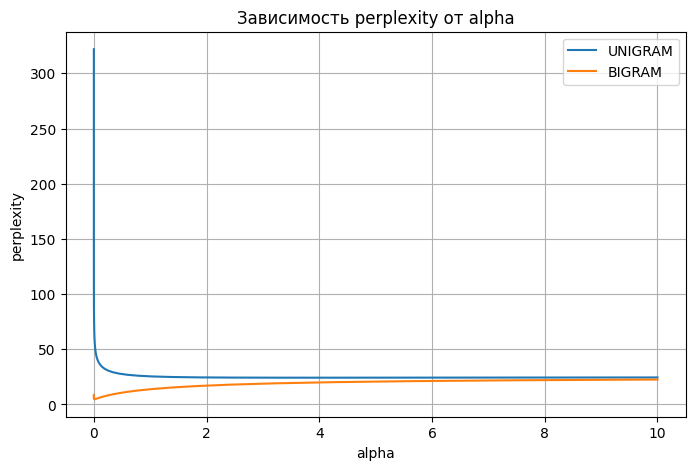

In [79]:
plt.figure(figsize=(8, 5))
plt.plot(hist_u[0],hist_u[1], label=f'UNIGRAM')
plt.plot(hist_b[0],hist_b[1], label=f'BIGRAM')
plt.xlabel('alpha')
plt.ylabel('perplexity')
plt.title(f'Зависимость perplexity от alpha')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
print(generate_sentence_unigram(alpha=alpha_u))
print(generate_sentence_bigram(alpha_b=alpha_b, alpha_u=alpha_u))

Это ловит дом доме кот птица построил джек джек пшеница.
Которая в птица синица которая часто ворует пшеницу которая в доме ловит и который построил.


In [81]:
print(generate_sentence_unigram())
print(generate_sentence_unigram(alpha=alpha_u))

Хранится пшеница весёлая доме в ворует часто тёмном весёлая пшеницу.
Который птица хранится построил хранится это которая построил пшеницу пугает.


In [83]:
print(generate_sentence_bigram())
print(generate_sentence_bigram(alpha_b=alpha_b, alpha_u=alpha_u))

В кот ловит пшеницу кот вот дом который синица которая в весёлая синица синица часто.
Дом который построил джек а это весёлая птица синица которая часто дом построил джек а.


# Отчет

## Сравнение униграмм и биграмм

По генерируемым предложениям можно понять, что униграмма вообще не смотрит на контекст и генерирует слова как попало, без какой либо связи. Биграма (особенно оптимизированная) уже связывает слова (например наречие перед глаголом, или местоимение после существительного для сложных предложений). Однако интересен тот факт, что биграмма любит зацикливаться `Ворует пшеницу которая часто ворует пшеницу которая часто ворует`.

## Анализ графиков

Здесь гораздо интереснее выглядят графики (униграмма убывает как показательная функция, а биграмма возрастает примерно как корень).
Устремим alpha -> 0, тогда вероятно превращаются в чистые MLE оценки, а при alpha -> inf, они у нас все вырождается по факту в равномерное распределение. Униграмма имеет простую структуру вероятностей => быстро переобучается при MLE оценках, так как тогда она жестко опирается на обучающую выборку. С другой стороны, чем ближе распределение к равномерному, тем с большей вероятностью она зацепит слова которых не было при обучении. С биграммой все сложней, структура вероятностей более сложная, модель чувствительнее к параметрам, окно баланса достаточно узкое, и модель изначально (при MLE) не сильно переобучена
